In [1]:
from keras.datasets import fashion_mnist as data
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
# !pip install wandb
# import wandb
# wandb.login()

In [3]:
# Flattening input training data each image of size 28x28 pixels into a vector of size 784
def FlattenInput(X_train, X_test):
  num_train = X_train.shape[0]
  num_test = X_test.shape[0]
  
  features = X_train.shape[1]*X_train.shape[2]  # 28x28 = 784
  X_train=X_train.reshape(num_train, features)
  X_test=X_test.reshape(num_test,features)
  

  X_train=np.transpose(X_train)
  X_test = np.transpose(X_test)
  

  X_train = X_train/255  # normalised data
  X_test = X_test/255
 

  return(X_train, X_test)

# One hot encoding of output labels of training data
def OneHotEncoding(Y_train,num_train):
  Y_train_orig= Y_train[:,:]

  Y_train=np.zeros([10,num_train])

  for i in range(num_train):
    index=Y_train_orig[0,i]
    Y_train[index,i]=1

  return(Y_train, Y_train_orig)



In [4]:
# Shuffles  training data
def ShuffleData(X_train, Y_train):
  m=X_train.shape[1]
  permutation = list(np.random.permutation(m))
  X_train = X_train[:, permutation]
  Y_train = Y_train[:, permutation]
  return(X_train,Y_train)




# Divides input training data into mini batches of given batch size
def GetMiniBatches(X_train, Y_train,mini_batch_size):
    m=X_train.shape[1]  
    num_batches = m//mini_batch_size
    X_mini_batches = []
    Y_mini_batches = []

    #X_train, Y_train = ShuffleData(X_train, Y_train)

    for i in range(num_batches):
      x=X_train[:,i*mini_batch_size:(i+1)*(mini_batch_size)]
      y=Y_train[:,i*mini_batch_size:(i+1)*(mini_batch_size)]
      X_mini_batches.append(x)
      Y_mini_batches.append(y)

    if m%mini_batch_size!=0:
      index = num_batches*mini_batch_size
      x=X_train[:,index:index+m%mini_batch_size]
      y=Y_train[:,index:index+m%mini_batch_size]
      X_mini_batches.append(x)
      Y_mini_batches.append(y)
    
    
    return(X_mini_batches, Y_mini_batches)     

In [5]:
# Activations and their derivatives


# Computes Relu activation function
def Relu(Z):

    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    return A

# Computes derivative of Relu Activation
def ReluGradient(z):
    dZ = np.zeros(z.shape) 
    dZ[z > 0] = 1
    assert (dZ.shape == z.shape)
    return dZ


# Computes Sigmoid activation function
def Sigmoid(z):
    a=1/(1+np.exp(-z))
    return(a)


# Computes derivative of Sigmoid Activation
def SigmoidGradient(z):
    a=Sigmoid(z)
    return(a*(1-a))

# Computes Tanh activation function
def Tanh(z):
  a=np.tanh(z)
  return(a)

# Computes derivative of Tanh Activation
def TanhGradient(z):
  a=Tanh(z)
  return(1-a**2)

#  Computes Softmax activation function
def Softmax(z):
    num=np.exp(z)
    den=np.sum(np.exp(z),axis=0)
    a=num/den
    return(a)



In [6]:

# Initialize weights using Xavier or Random weight initialisations
def InitializeWeights(layers, params, M, R, initialiser):
  seed=3
  np.random.seed(seed)
  for i in range(1,len(layers)):
      if(initialiser=="xavier"):
        params["W"+str(i)]=np.random.randn(layers[i],layers[i-1])*np.sqrt(2 / (layers[i]+layers[i-1]))
      elif(initialiser=="random"):
        params["W"+str(i)]=np.random.normal(2,1,[layers[i],layers[i-1]])
        

      params["b"+str(i)]=np.zeros([layers[i],1])
      M["W"+str(i)]=np.zeros([layers[i],layers[i-1]])
      M["b"+str(i)]=np.zeros([layers[i],1])
      R["W"+str(i)]=np.zeros([layers[i],layers[i-1]])
      R["b"+str(i)]=np.zeros([layers[i],1])
  return(params, M, R)


# computes loss through cross entropy error function
def CrossEntropyError(a,Y,params,layers,weight_decay):
    m=a.shape[1]
    error=-(np.sum(np.sum(Y*np.log(a),axis=1),axis=0))
    #error=-np.sum(Y*np.log(a)+(1-Y)*np.log(1-a))/m
    for i in range(1,len(layers)):
      regu_cost = (weight_decay/2)*np.sum(np.sum(np.square(params["W"+str(i)]),axis=1),axis=0)
    error+=regu_cost
    return(error)


# computes loss through Mean Squared Error Function   
def MeanSquaredError(a,Y,params,layers,weight_decay):
    m=a.shape[1]
    error= np.sum(np.sum(np.square(a-Y),axis=1),axis=0)/2
    for i in range(1,len(layers)):
      regu_cost = (weight_decay/2)*np.sum(np.sum(np.square(params["W"+str(i)]),axis=1),axis=0)
    error+=regu_cost
    return(error)


# Computes pre-activations and activations through forward propagation
def ForwardPropagation(params,layers,X,activation):
    
    a=X
    n=len(layers)-1
    Z=[]
    A=[]
    A.append(X)
    Z.append(X)
    for i in range(1,len(layers)-1):
        W=params["W"+str(i)]
        b=params["b"+str(i)]
        z = np.dot(W,a)+b
        if(activation=="relu"):
          a = Relu(z)
        elif(activation=="sigmoid"):
          a = Sigmoid(z)
        elif(activation=="tanh"):
          a = Tanh(z)
        A.append(a)
        Z.append(z)
    W=params["W"+str(n)]
    b=params["b"+str(n)]
    z = np.dot(W,a)+b
    a = Softmax(z)
    Z.append(z)
    A.append(a)
    return(A,Z)


# Computes gradients of weights through backward propagation
def BackwardPropagation(params, layers, Z, A, learning_rate, Y, activation, loss_function):
    m=Y.shape[1]
    l=len(layers)-1
    if(loss_function=='cross-entropy'):
        dz= A[l]-Y
    elif(loss_function=='MSE'):
        dz= np.multiply((A[l]- Y), np.multiply(A[l], (1 - A[l])))
      
    gradients={}
    while(l>=0):
        dw = np.dot(dz,np.transpose(A[l-1]))/m
        db = np.sum(dz,axis=1)/m 
        db=db.reshape(db.shape[0],1)
        gradients["dw"+str(l)]=dw
        gradients["db"+str(l)]=db
        if(l>=2):
            da= np.dot(np.transpose(params["W"+str(l)]), dz)
            if(activation=="relu"):
              dz = da*ReluGradient(Z[l-1])
            elif(activation=="sigmoid"):
              dz = da*SigmoidGradient(Z[l-1])
            elif(activation=="tanh"):
              dz = da*TanhGradient(Z[l-1])
        l=l-1
    return(gradients)

        



In [7]:

# Updates weights through Stochastic Gradient Descent
def UpdateWeightsSGD(m, params,gradients,layers, learning_rate, weight_decay):
    for i in range(1,len(layers)):
        params["W"+str(i)]-= learning_rate*gradients["dw"+str(i)]
        params["b"+str(i)]-= learning_rate*gradients["db"+str(i)]
        params["W"+str(i)]-= learning_rate*(weight_decay/m)*params["W"+str(i)]
        params["b"+str(i)]-= learning_rate*(weight_decay/m)*params["b"+str(i)]
    return(params)


# Updates weights through Momentum Gradient Descent
def UpdateWeightsMomentum(m, params, gradients, M, layers, learning_rate,weight_decay, beta1):
    for i in range(1,len(layers)):
        M["W"+str(i)]=beta1*M["W"+str(i)]+(1-beta1)*gradients["dw"+str(i)]
        M["b"+str(i)]=beta1*M["b"+str(i)]+(1-beta1)*gradients["db"+str(i)]
        params["W"+str(i)]-= learning_rate* M["W"+str(i)]
        params["b"+str(i)]-= learning_rate*M["b"+str(i)]
        params["W"+str(i)]-= learning_rate*(weight_decay/m)*params["W"+str(i)]
        params["b"+str(i)]-= learning_rate*(weight_decay/m)*params["b"+str(i)]
    return(params,M)


# Updates weights through RMSprop Gradient Descent
def UpdateWeightsRMS(m, params, gradients,R, layers, learning_rate, weight_decay, beta1 ,eps):

    for i in range(1,len(layers)):
        R["W"+str(i)]=beta1*R["W"+str(i)]+(1-beta1)*np.power(gradients["dw"+str(i)],2)
        R["b"+str(i)]=beta1*R["b"+str(i)]+(1-beta1)*np.power(gradients["db"+str(i)],2)
        params["W"+str(i)]-= (learning_rate*gradients["dw"+str(i)])/(np.sqrt(R["W"+str(i)])+eps)
        params["b"+str(i)]-= (learning_rate*gradients["db"+str(i)])/(np.sqrt(R["b"+str(i)])+eps)
        params["W"+str(i)]-= learning_rate*(weight_decay/m)*params["W"+str(i)]
        params["b"+str(i)]-= learning_rate*(weight_decay/m)*params["b"+str(i)]
    return(params,R)


# Updates weights through Nesterov Accelerated Gradient Descent
def UpdateWeightsNesterov(m, params, lookahead_grads, M, layers, learning_rate, weight_decay, beta1):
    
    for i in range(1,len(layers)):
        M["W"+str(i)]=beta1*M["W"+str(i)]+(1-beta1)*lookahead_grads["dw"+str(i)]
        M["b"+str(i)]=beta1*M["b"+str(i)]+(1-beta1)*lookahead_grads["db"+str(i)]
        params["W"+str(i)]-= learning_rate* M["W"+str(i)]
        params["b"+str(i)]-= learning_rate*M["b"+str(i)]
        params["W"+str(i)]-= learning_rate*(weight_decay/m)*params["W"+str(i)]
        params["b"+str(i)]-= learning_rate*(weight_decay/m)*params["b"+str(i)]
    return(params,M)

# Updates weights through Nesterov Adam Gradient Descent
def UpdateWeightsNAdam(m, params, lookahead_grads, layers, M, R, learning_rate, weight_decay, beta1, beta2, eps, t):
    M_c={}
    R_c={}
    for i in range(1,len(layers)):
        M["W"+str(i)]=beta1*M["W"+str(i)]+(1-beta1)*lookahead_grads["dw"+str(i)]
        M["b"+str(i)]=beta1*M["b"+str(i)]+(1-beta1)*lookahead_grads["db"+str(i)]

        M_c["W"+str(i)]=M["W"+str(i)]/(1-np.power(beta1,t))   # bias correction
        M_c["b"+str(i)]=M["b"+str(i)]/(1-np.power(beta1,t))
        R["W"+str(i)]=beta2*R["W"+str(i)]+(1-beta2)*np.power(lookahead_grads["dw"+str(i)],2)
        R["b"+str(i)]=beta2*R["b"+str(i)]+(1-beta2)*np.power(lookahead_grads["db"+str(i)],2)

        R_c["W"+str(i)]=R["W"+str(i)]/(1-np.power(beta2,t))     # bias correction
        R_c["b"+str(i)]=R["b"+str(i)]/(1-np.power(beta2,t))
        params["W"+str(i)]-= (learning_rate*M_c["W"+str(i)])/(np.sqrt(R_c["W"+str(i)])+eps)
        params["b"+str(i)]-= (learning_rate*M_c["b"+str(i)])/(np.sqrt(R_c["b"+str(i)])+eps)
        params["W"+str(i)]-= learning_rate*(weight_decay/m)*params["W"+str(i)]
        params["b"+str(i)]-= learning_rate*(weight_decay/m)*params["b"+str(i)]
        
    return(params,M,R)

# Updates weights through Adam Gradient Descent
def UpdateWeightsAdam(m, params, gradients, layers, M, R, learning_rate, weight_decay, beta1, beta2, eps, t):
    M_c={}
    R_c={}
    for i in range(1,len(layers)):
        M["W"+str(i)]=beta1*M["W"+str(i)]+(1-beta1)*gradients["dw"+str(i)]
        M["b"+str(i)]=beta1*M["b"+str(i)]+(1-beta1)*gradients["db"+str(i)]

        M_c["W"+str(i)]=M["W"+str(i)]/(1-np.power(beta1,t))   # bias correction
        M_c["b"+str(i)]=M["b"+str(i)]/(1-np.power(beta1,t))
        R["W"+str(i)]=beta2*R["W"+str(i)]+(1-beta2)*np.power(gradients["dw"+str(i)],2)
        R["b"+str(i)]=beta2*R["b"+str(i)]+(1-beta2)*np.power(gradients["db"+str(i)],2)

        R_c["W"+str(i)]=R["W"+str(i)]/(1-np.power(beta2,t))    # bias correction
        R_c["b"+str(i)]=R["b"+str(i)]/(1-np.power(beta2,t))
        params["W"+str(i)]-= (learning_rate*M_c["W"+str(i)])/(np.sqrt(R_c["W"+str(i)])+eps)
        params["b"+str(i)]-= (learning_rate*M_c["b"+str(i)])/(np.sqrt(R_c["b"+str(i)])+eps)
        params["W"+str(i)]-= learning_rate*(weight_decay/m)*params["W"+str(i)]
        params["b"+str(i)]-= learning_rate*(weight_decay/m)*params["b"+str(i)]
    return(params,M,R)

In [8]:
# predicts training data accuracy, validation data accuracy, test data accuracy of given model
def Predict(params, layers, X_train, X_test, Y_train_orig, Y_test,activation,weight_decay):
  m=X_validation.shape[1]
  A,Z=ForwardPropagation(params, layers, X_validation,activation)
  val_error = CrossEntropyError(A[-1], Y_validation,params,layers,weight_decay)
  val_error = val_error/m

  num_train = X_train.shape[1]
  num_test = X_test.shape[1]
  num_validation = X_validation.shape[1]
  
  #predicts training data accuracy
  A,Z=ForwardPropagation(params, layers, X_train, activation)
  pred=A[-1]
  max_index = np.argmax(pred, axis=0)
  count=0
  for i in range(num_train):
      if(Y_train_orig[0,i]==max_index[i]):
          count+=1
  train_accuracy = (count/num_train)*100

  #predicts validation data accuracy
  A,Z=ForwardPropagation(params, layers, X_validation, activation)
  pred=A[-1]
  max_index = np.argmax(pred, axis=0)
  count=0
  for i in range(num_validation):
      if(Y_validation_orig[0,i]==max_index[i]):
          count+=1

  Y_pred=max_index

  

  val_accuracy = (count/num_validation)*100

  #predicts testing data accuracy
  A,Z=ForwardPropagation(params, layers, X_test,activation)
  pred=A[-1]
  max_index = np.argmax(pred, axis=0)
  count=0
  for i in range(num_test):
      if(Y_test[0,i]==max_index[i]):
          count+=1

  test_accuracy = (count/num_test)*100

  return(val_error,train_accuracy,val_accuracy,test_accuracy,Y_pred)

  
          
      
# creates confusion matrix



In [9]:
# Main Component for training our model

def TrainModel():
    
    # flexible architecture, taking user input
    layers=[X_train.shape[0]]
    hidden_layers= int(input("Enter number of hidden layers"))       # eg: 3,4,5
    for i in range(0,hidden_layers):
        layers.append(int(input("enter the number of nodes in "+str(i+1)+" hidden layer.")))
    layers.append(Y_train.shape[0])
    
    
    learning_rate=0.001    # eg: 0.001, 0.0001
    weight_decay=0          # eg:  0, 0.0005, 0.5
    optimiser="adam"       # eg: "sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"
    activation="relu"       # eg: 'sigmoid', 'tanh','relu'
    epochs=10               # eg: 5,10
    mini_batch_size=16      # eg: 16, 32, 64
    initialiser='xavier'    # eg: "random", "xavier"

    
    loss_function='cross-entropy'
    
    training_errors=[]
    validation_errors=[]
    
    params={}
    M={}
    R={}
    lookahead_params={}

    #wandb.run.name = "hl_" + str(wandb.config.hidden_layers) +"_hn_" + str(wandb.config.size_hidden_layer)  + "_opt_" + wandb.config.optimiser +"_lr_" + str(wandb.config.learning_rate)+ "_init_" + wandb.config.initialiser +"_bs_"+str(wandb.config.batch_size)+"_ac_" + wandb.config.activation+ "_wd_"+str(weight_decay)

    
    # initialise weights
    params, M, R = InitializeWeights(layers, params, M, R,initialiser)
    (X_mini_batches, Y_mini_batches) = GetMiniBatches(X_train, Y_train,mini_batch_size)

    epoch=1
    beta1=0.9  # hyperparameter for exponentially weighted averages of momentum
    beta2=0.999  # hyperparameter for exponentially weighted average of  rms
    eps=1e-8     # small real value so that denominator do not become zero
   
    m=X_train.shape[1]
    
    t=0

    while(epoch<=epochs):
        train_error=0
        for i in range(len(X_mini_batches)):
          X_train_mini=X_mini_batches[i]
          Y_train_mini=Y_mini_batches[i]

          # Forward Propagation
          A,Z=ForwardPropagation(params, layers, X_train_mini,activation)

          # Computes Loss function
          if(loss_function == "cross-entropy"):
            train_error += CrossEntropyError(A[-1], Y_train_mini,params,layers,weight_decay)
          elif(loss_function == "MSE"):
            train_error += MeanSquaredError(A[-1],Y_train_mini,params,layers,weight_decay)
          
          
          if(optimiser=="nadam" or optimiser=="nesterov"):

              # Initialising lookaheads for nadam and nesterov
              for i in range(1,len(layers)):
                lookahead_params["W"+str(i)]=params["W"+str(i)]-M["W"+str(i)]
                lookahead_params["b"+str(i)]=params["b"+str(i)]-M["b"+str(i)]

              # Back propagation for nada and nesterov
              lookahead_grads=BackwardPropagation(lookahead_params, layers,Z, A, learning_rate, Y_train_mini,activation,loss_function)

              # Updating weights
              if(optimiser=="nesterov"):
                params, M = UpdateWeightsNesterov(num_train, params, lookahead_grads, M, layers, learning_rate, weight_decay, beta1)
              elif(optimiser=="nadam"):
                t=t+1
                params,M,R = UpdateWeightsNAdam(num_train, params, lookahead_grads, layers, M, R, learning_rate, weight_decay, beta1,beta2,eps,t)

          else:
              # Back propagation sgd, momentum, rmsprop , adam
              gradients=BackwardPropagation(params, layers, Z , A, learning_rate, Y_train_mini, activation, loss_function)

              # updating weights
              if(optimiser=="sgd"):
                params = UpdateWeightsSGD(num_train, params,gradients,layers, learning_rate, weight_decay)
              elif(optimiser=="momentum"):
                params,M = UpdateWeightsMomentum(num_train, params, gradients, M, layers, learning_rate,weight_decay, beta1)
              elif(optimiser=="rmsprop"):
                params, R = UpdateWeightsRMS(num_train, params, gradients, R, layers, learning_rate, weight_decay, beta1 ,eps)
              elif(optimiser=="adam"):
                t=t+1
                params, M, R = UpdateWeightsAdam(num_train,params, gradients, layers, M, R, learning_rate, weight_decay, beta1, beta2, eps, t)


        # average training error
        train_error=train_error/m
        training_errors.append(train_error)

        # predicts training data accuracy, validation data accuracy, test data accuracy of given model
        val_error, train_accuracy, val_accuracy, test_accuracy, Y_pred = Predict(params, layers, X_train, X_test, Y_train_orig, Y_test,activation, weight_decay)
        validation_errors.append(val_error)
        
        epoch+=1
        print("epoch: "+str(10), "training error: "+str(train_error), "training accuracy: "+str(train_accuracy), "validation error: "+str(val_error), "validation accuracy: "+str(val_accuracy))
        
    #predicts training data accuracy, validation data accuracy, test data accuracy of given model
    val_error, train_accuracy, val_accuracy, test_accuracy, Y_pred = Predict(params, layers, X_train, X_test, Y_train_orig, Y_test,activation, weight_decay)

    
    plt.plot(training_errors)
    plt.plot(validation_errors)
    plt.xlabel("EPOCHS")
    plt.ylabel("Loss value")
    
   

In [10]:

# Loading Fashion MNIST dataset
(X, Y), (X_test, Y_test) = data.load_data()

# Flattening of Input data
(X, X_test) = FlattenInput(X, X_test)

Y = Y.reshape(1, X.shape[1])
Y_test= Y_test.reshape(1, X_test.shape[1])


# Shuffling of training data
X,Y = ShuffleData(X, Y)




# Splitting input training data into training data and validation data in the ratio of 9:1
num_train= int(0.9*X.shape[1])
num_validation = int(0.1*X.shape[1])
num_test=X_test.shape[1]



X_train = X[:,:num_train]
X_validation = X[:,num_train:]

Y_train = Y[:,:num_train]
Y_validation =  Y[:,num_train:]


# One Hot Encoding of output labels of training data
(Y_train,Y_train_orig)= OneHotEncoding(Y_train,num_train)

# One Hot Encoding of output labels of validation data
(Y_validation,Y_validation_orig)= OneHotEncoding(Y_validation,num_validation)


print(X_train.shape,Y_train.shape, X_test.shape, Y_test.shape, X_validation.shape, Y_validation.shape)

(784, 54000) (10, 54000) (784, 10000) (1, 10000) (784, 6000) (10, 6000)


Enter number of hidden layers3
enter the number of nodes in 1 hidden layer.64
enter the number of nodes in 2 hidden layer.64
enter the number of nodes in 3 hidden layer.64
epoch: 10 training error: 0.5083525013769101 training accuracy: 85.23148148148148 validation error: 0.443779202714026 validation accuracy: 83.0
epoch: 10 training error: 0.3804931521412127 training accuracy: 87.5 validation error: 0.3899476471076104 validation accuracy: 85.43333333333332
epoch: 10 training error: 0.3435784598208189 training accuracy: 87.92777777777778 validation error: 0.37808779348448424 validation accuracy: 85.88333333333334
epoch: 10 training error: 0.3204213495115603 training accuracy: 87.97592592592592 validation error: 0.38732619323349377 validation accuracy: 85.86666666666667
epoch: 10 training error: 0.30337613972202615 training accuracy: 89.46111111111111 validation error: 0.34884952865093427 validation accuracy: 87.11666666666666
epoch: 10 training error: 0.28948596428214535 training accura

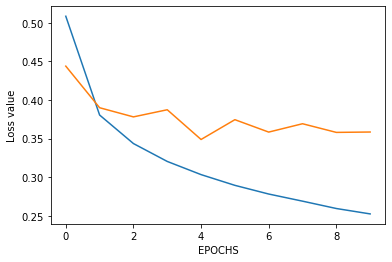

In [11]:
# calling wandb agent to perform hyperparameter sweep
# wandb.agent(sweep_id, TrainModel,count = 1)
TrainModel()